This is a notebook that reconstructs the electronic wavefunctions from the planewave coefficients computed by the electronic structure code Abinit. According to Bloch's theorem, the electronic wavefunction of a periodic crystal takes the following form
\begin{equation}
    \psi_{n\boldsymbol{k}}(\boldsymbol{r}) = e^{i\boldsymbol{k}\cdot\boldsymbol{r}}u_{n\boldsymbol{k}}(\boldsymbol{r}),
\end{equation}
i.e. a planewave modulated by a periodic envelop $u_{n\boldsymbol{k}}(\boldsymbol{r}+\boldsymbol{R}) = u_{n\boldsymbol{k}}(\boldsymbol{r})$, where $\boldsymbol{R}$ is any lattice vector. Here, $\boldsymbol{k}$ is the crystal momentum and $n$ is the band index. Abinit is planewave code, meaning the periodic part of the Bloch functions are expanded as planewaves
\begin{equation}
    u_{n\boldsymbol{k}} = \frac{1}{\sqrt{\Omega}}\sum_{\boldsymbol{G}}e^{i\boldsymbol{G}\cdot\boldsymbol{r}}C_{n\boldsymbol{k}}(\boldsymbol{G}),
\end{equation}
where $\Omega$ is the unit cell volume, $\boldsymbol{G}$ are the reciprocal lattice vectors, and $C_{n\boldsymbol{k}}(\boldsymbol{G})$ are the coefficients computed by Abinit. Putting these two equations together, we get the following expression for the wavefunction
\begin{equation}
    \psi_{n\boldsymbol{k}}(\boldsymbol{r})=\frac{1}{\sqrt{\Omega}}\sum_{\boldsymbol{G}}e^{i\boldsymbol{r}\cdot(\boldsymbol{k}+\boldsymbol{G})}C_{n\boldsymbol{k}}(\boldsymbol{G}).
\end{equation}

$\mathbf{G}\cdot\mathbf{r}$
$\boldsymbol{G}$

In [18]:
# imports 
import numpy as np

from electron_defect_interaction.utils.pw_utils import *
from electron_defect_interaction.utils.get_utils import *
from electron_defect_interaction.analysis.wfk.wfk import * 
import matplotlib.pyplot as plt

import os
os.chdir("/Users/gregou/electron_defect_interaction")

plt.rcParams.update({
    "text.usetex": True,                 # use LaTeX for all text
    "font.family": "serif",              # match your document font
    "font.serif": ["Computer Modern"],   # same as LaTeX default
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.titlesize": 16,
    "legend.fontsize": 13,
    "figure.dpi": 150,
    "axes.linewidth": 1.0,
})

In [5]:
# Path to the Abinit WFK file for 5x5x1 MP grid graphene unit cell
WFK_551 = "data/graphene/unit_cell/5x5x1/abinit/sp2/graphene_w90_5x5x1o_DS2_WFK.nc"

# Getting necessary ingredients
C_nk, npw = get_C_nk(WFK_551) # planewave coefficients
G_red = get_G_red(WFK_551) # reciprocal lattice vectors
k_red = get_KPT(WFK_551) # kpoint grid
A, Omega = get_A_volume(WFK_551) # direct primitive lattice vectors and volume of primitive cell

print(G_red.shape)

(25, 6889, 3)


In [6]:
# Choosing the FFT grid size, rule of thumb, Ni >= 2*Gmax_i+1, where Gmax is the max G-vector of all k-points and i=x,y,z
Gmax = np.array([0, 0, 0], dtype=int)
for ik in range(k_red.shape[0]):
    npw_k = npw[ik]
    Gk = G_red[ik, :npw_k, :]
    Gmax = np.maximum(Gmax, np.max(np.abs(Gk), axis=0))

Nx, Ny, Nz = grid_from_Gmax(Gmax)
print('Nx, Ny, Nz must be larger than: ', Nx, Ny, Nz)


Nx, Ny, Nz must be larger than:  15 15 105


In [7]:
Nx=500; Ny=500; Nz=105

In [8]:
# Computing wavefunction on a uniform grid
psi_nk_5x5x1, ngfft = compute_psi_nk(C_nk, npw, G_red, k_red, Omega, Nx=250, Ny=250, Nz=105, complex64=False) # (nband, nkpt, Nx, Ny, Nz) array
print(ngfft)
# Checking normalization
Nx, Ny, Nz = ngfft
# norm = np.sum(np.abs(psi_nk_5x5x1)**2, axis=(2,3,4)) * (Omega/(Nx*Ny*Nz))
# assert np.allclose(norm, 1.0, atol=1e-3), f"Wavefunction not normalized! Norm = {norm}"

Computed  1 out of 25 k-points
Computed  2 out of 25 k-points
Computed  3 out of 25 k-points
Computed  4 out of 25 k-points
Computed  5 out of 25 k-points
Computed  6 out of 25 k-points
Computed  7 out of 25 k-points
Computed  8 out of 25 k-points
Computed  9 out of 25 k-points
Computed  10 out of 25 k-points
Computed  11 out of 25 k-points
Computed  12 out of 25 k-points
Computed  13 out of 25 k-points
Computed  14 out of 25 k-points
Computed  15 out of 25 k-points
Computed  16 out of 25 k-points
Computed  17 out of 25 k-points
Computed  18 out of 25 k-points
Computed  19 out of 25 k-points
Computed  20 out of 25 k-points
Computed  21 out of 25 k-points
Computed  22 out of 25 k-points
Computed  23 out of 25 k-points
Computed  24 out of 25 k-points
Computed  25 out of 25 k-points
(250, 250, 105)


In [57]:
# normalization check
N = np.prod(ngfft)
norm = np.sum(np.abs(psi_nk_5x5x1)**2, axis=(2,3,4)) * (Omega/N)
assert np.allclose(norm, 1.0, atol=1e-6), f"Wavefunction not normalized! Norm = {norm}"

In [7]:
# Let's test on finer kpoint grid
WFK_20x20x1 = "data/graphene/unit_cell/20x20x1/sp2/abinit/graphene_w90_20x20x1o_DS2_WFK.nc"

# Getting necessary ingredients
C_nk, npw = get_C_nk(WFK_20x20x1) # planewave coefficients and number of active planewaves
G_red = get_G(WFK_20x20x1) # reciprocal lattice vectors in reduced coordinates
k_red = get_KPT(WFK_20x20x1) # kpoint grid in reduced coordinates
A, Omega = get_A_volume(WFK_20x20x1) # direct primitive lattice vectors and volume of primitive cell

psi_nk_20x20x1, ngfft = compute_psi_nk(C_nk, npw, G_red, k_red, Omega, Nx=None, Ny=None, Nz=None, complex64=False) # (nband, nkpt, Nx, Ny, Nz) array

Computed  1 out of 400 k-points
Computed  2 out of 400 k-points
Computed  3 out of 400 k-points
Computed  4 out of 400 k-points
Computed  5 out of 400 k-points
Computed  6 out of 400 k-points
Computed  7 out of 400 k-points
Computed  8 out of 400 k-points
Computed  9 out of 400 k-points
Computed  10 out of 400 k-points
Computed  11 out of 400 k-points
Computed  12 out of 400 k-points
Computed  13 out of 400 k-points
Computed  14 out of 400 k-points
Computed  15 out of 400 k-points
Computed  16 out of 400 k-points
Computed  17 out of 400 k-points
Computed  18 out of 400 k-points
Computed  19 out of 400 k-points
Computed  20 out of 400 k-points
Computed  21 out of 400 k-points
Computed  22 out of 400 k-points
Computed  23 out of 400 k-points
Computed  24 out of 400 k-points
Computed  25 out of 400 k-points
Computed  26 out of 400 k-points
Computed  27 out of 400 k-points
Computed  28 out of 400 k-points
Computed  29 out of 400 k-points
Computed  30 out of 400 k-points
Computed  31 out of

In [ ]:
# normalization check
N = np.prod(ngfft)
norm = np.sum(np.abs(psi_nk_20x20x1)**2, axis=(2,3,4)) * (Omega/N)
assert np.allclose(norm, 1.0, atol=1e-6), f"Wavefunction not normalized! Norm = {norm}"

(16, 400, 15, 15, 105)


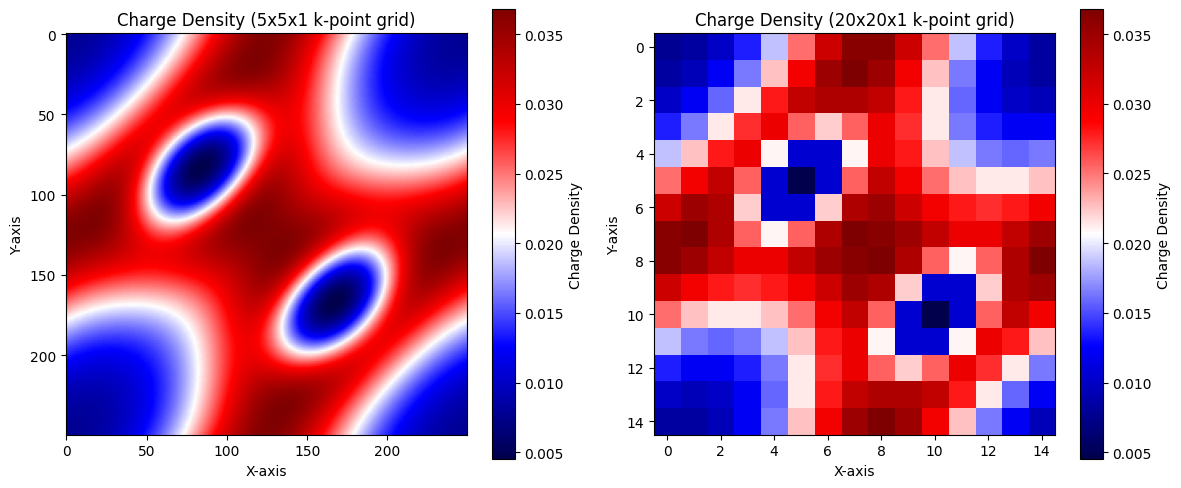

In [53]:
n=0
psi_5x5x1 = psi_nk_5x5x1[n, 0, :, :, :]  # pi bands (n=4,5), shape (Nx, Ny, Nz)
psi_20x20x1 = psi_nk_20x20x1[n, 0, :, :, :]  # pi bands (n=4,5), shape (Nx, Ny, Nz)

# Charge density = |psi|^2
rho_5x5x1 = np.abs(psi_5x5x1)**2
rho_20x20x1 = np.abs(psi_20x20x1)**2

# plotting charge density
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rho_5x5x1[:, :, 0], cmap='seismic')
plt.colorbar(label='Charge Density')
plt.title('Charge Density (5x5x1 k-point grid)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.subplot(1, 2, 2)
plt.imshow(rho_20x20x1[:, :, 0], cmap='seismic')
plt.colorbar(label='Charge Density')
plt.title('Charge Density (20x20x1 k-point grid)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.tight_layout()
plt.show()

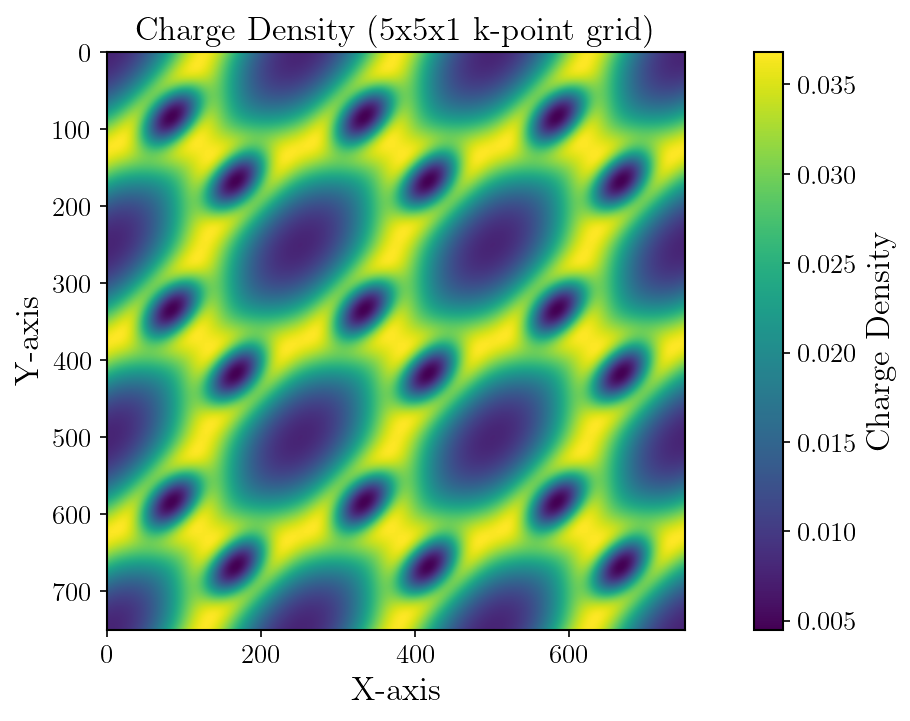

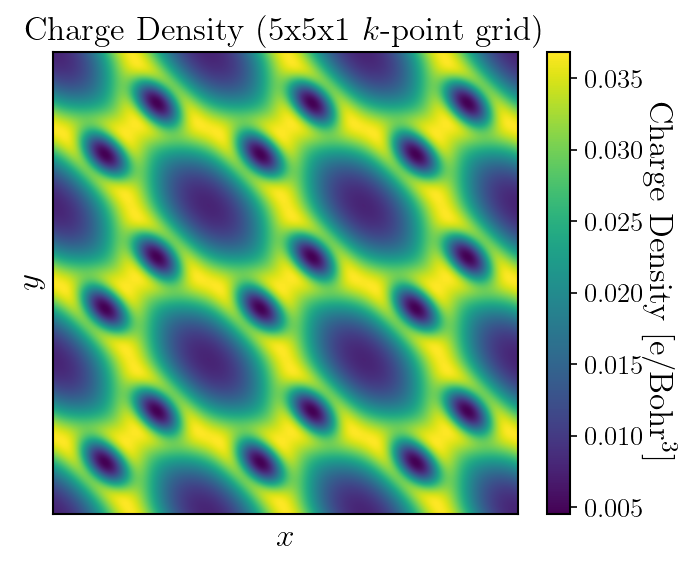

In [24]:
# Plotting a supercell!
import matplotlib.pyplot as plt
#  band and kpoint index
n=0; ik=0; iz=0

psi = psi_nk_5x5x1[n, ik, :, :, iz]  # shape (Nx, Ny)
density = np.abs(psi)**2  # shape (Nx, Ny)

# tile density to make 5x5 supercell
density_5x5 = np.tile(density, (3, 3))  # shape (5*Nx, 5*Ny)

plt.figure(figsize=(12, 5))
plt.imshow(density_5x5, cmap='viridis')
plt.colorbar(label='Charge Density')
plt.title('Charge Density (5x5x1 k-point grid)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))  # inches
im = ax.imshow(density_5x5,
               origin='lower',          # puts (0,0) bottom-left
               cmap='viridis',          # perceptually uniform colormap
               aspect='auto')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'Charge Density [e/Bohr$^3$]', rotation=270, labelpad=15)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$ ')
ax.set_title(r'Charge Density (5x5x1 $k$-point grid)')
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)